In [1]:
using Revise, Plots, LinearAlgebra, LaTeXStrings, Random, BenchmarkTools

In [2]:
includet("../src/SparseSpikes.jl")
using .SparseSpikes

ErrorException: c:\Users\ladis\OneDrive - University of Warwick\Year 4\Super resolution\Codes\SparseSpikes\examples\src\SparseSpikes.jl is not a file

Define ground truth amplitudes and positions

In [3]:
domain  = [[0, 1], [0, 1]]

2-element Vector{Vector{Int64}}:
 [0, 1]
 [0, 1]

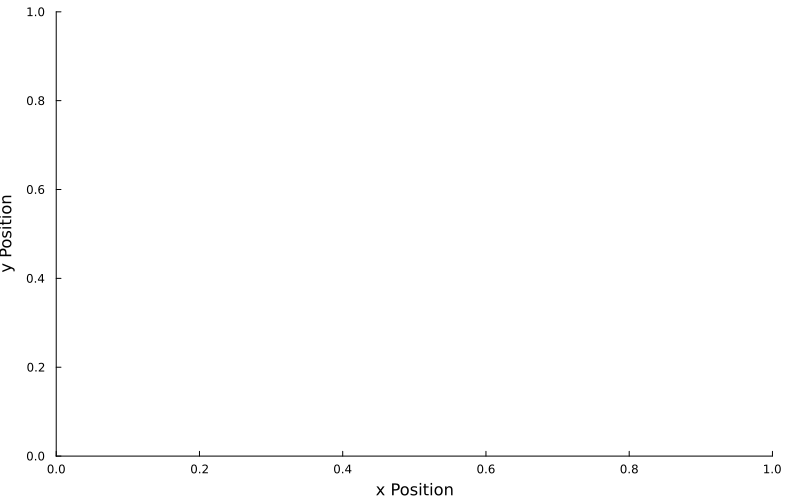

In [112]:
# Define the plot
num_points = 64

plt_grid_x1 = [domain[1][1] + i * (domain[1][2] - domain[1][1]) / num_points for j in 0:num_points, i in 0:num_points]
plt_grid_x2 = [domain[2][1] + j * (domain[2][2] - domain[2][1]) / num_points for j in 0:num_points, i in 0:num_points]

grid = range(0, stop=1, length=(num_points + 1))
plot_size = (400, 250) .* 2
plt = heatmap(xlims=domain[1], ylims=domain[2], xlabel="x Position", ylabel="y Position", color=:viridis, colorbar_title="Amplitude", size=plot_size, grid=false)

In [113]:
ops = gaussian_operators_2D(0.02, plt_grid_x1, plt_grid_x2)

Operators(var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}(var"#gauss2D#28"{Matrix{Float64}, Float64}([0.0 0.0; 0.0 0.015625; … ; 1.0 0.984375; 1.0 1.0], 1250.0), 4225), var"#Φ#30"{var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}}(var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}(var"#gauss2D#28"{Matrix{Float64}, Float64}([0.0 0.0; 0.0 0.015625; … ; 1.0 0.984375; 1.0 1.0], 1250.0), 4225)), var"#adjΦ#31"{Matrix{Float64}, Matrix{Float64}, var"#adjΦ#27#32"{var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}}}([0.0 0.015625 … 0.984375 1.0; 0.0 0.015625 … 0.984375 1.0; … ; 0.0 0.015625 … 0.984375 1.0; 0.0 0.015625 … 0.984375 1.0], [0.0 0.0 … 0.0 0.0; 0.015625 0.015625 … 0.015625 0.015625; … ; 0.984375 0.984375 … 0.984375 0.984375; 1.0 1.0 … 1.0 1.0], var"#adjΦ#27#32"{var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}}(var"#ϕ#29"{var"#gauss2D#28"{Matrix{Float64}, Float64}, Int64}(var"#gauss2D#28"{Matrix{Float64}, Float64}([0.0 0.0; 0

## Pre-certificate

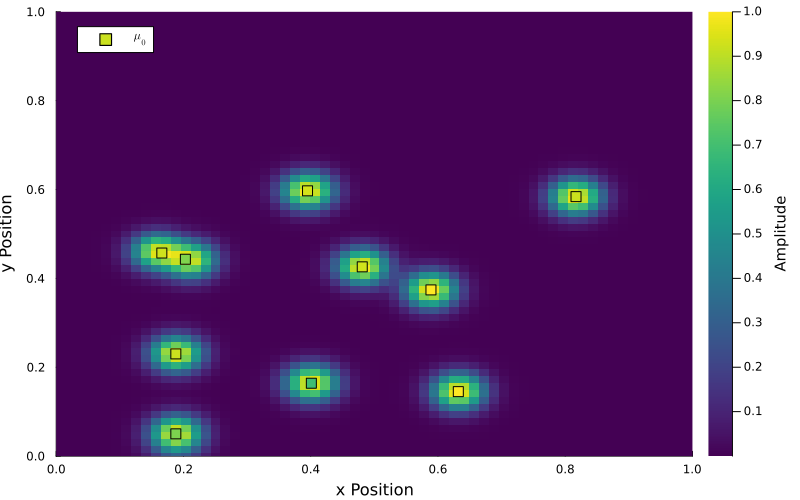

In [302]:
n_spikes = 10

Random.seed!(18)


# Ensure values are within the domain [0, 1] and not too concentrated around the origin
x0 = [rand(n_spikes), rand(n_spikes)]
x0 = [round.(x0[1], digits=3), round.(x0[2], digits=3)]

a0 = clamp.(abs.(round.(rand(Normal(0.9, 0.1), n_spikes), digits=3)), 0, 1)

# x0 = [[0.5], [0.5]]
# a0 = [1.0]

μ0 = DiscreteMeasure(x0, a0)

ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

heatmap!(plt_cert, grid, grid, ηV, color=:viridis)
plot_spikes!(plt_cert, μ0, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=1)

In [303]:
maximum(abs.(ηV))

0.9939730040138047

### SFW

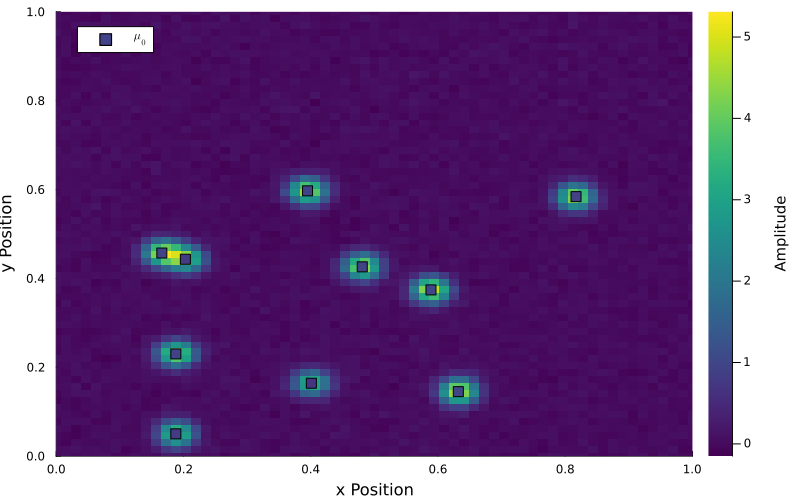

In [304]:
y0 = ops.Φ(μ0...)

function add_noise(y0, noise_level)
    sigma = noise_level * norm(y0)
    w = randn(length(y0))
    w = w / norm(w) * sigma
    y = y0 + w
    return y
end

# Add noise to the observation y = y0 + w
noise_level = 0.1
Random.seed!(1)
y = add_noise(y0, noise_level)

plt_obs = deepcopy(plt)

heatmap!(plt_obs, grid, grid, reshape(y, size(plt_grid_x1)) .* 50, color=:viridis)
plot_spikes!(plt_obs, μ0, label=L"μ_0", marker=:square, markersize=5, markerstrokewidth=1)

In [281]:
λ = 0.04noise_level

0.004

BFGS on L1 norm

DiscreteMeasure([[0.20247450904563627, 0.39520960586369197, 0.6320755318620115, 0.18790465639503345, 0.8167668954552191, 0.1879440630197667, 0.5891229922106006, 0.4014175388416599, 0.48099904432168333, 0.1671021076879338], [0.44333816214530714, 0.5969474218588541, 0.14502396488445463, 0.0499965169910783, 0.5841783703964396, 0.23009930405977122, 0.37403190482284154, 0.16396355159372658, 0.4260563791587405, 0.4564403518396866]], [0.7332124770571365, 0.8629514259921975, 0.9189637996337879, 0.722738546031877, 0.8438057730331445, 0.8474945455013969, 0.9281621487694569, 0.6115571008108722, 0.8496158513998925, 0.86667969933371], 2, 10)

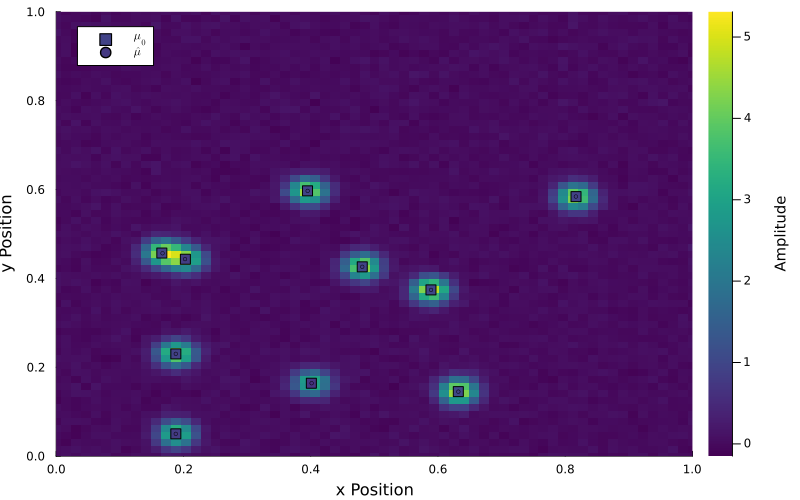

In [305]:
prob = BLASSO(y, ops, domain, λ)
solve!(prob, options=Dict(:maxits => length(a0) + 10, :positivity => true))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)

Iter     Function value   Gradient norm 
     0     7.646396e-02     2.567629e-01
 * time: 0.006999969482421875
     1     7.549148e-02     5.587595e-02
 * time: 0.11999988555908203
     2     7.540760e-02     4.741316e-02
 * time: 0.2389998435974121
     3     7.528483e-02     7.435494e-02
 * time: 0.31399989128112793
     4     7.523696e-02     1.388785e-02
 * time: 0.3939998149871826
     5     7.522437e-02     8.094226e-03
 * time: 0.46700000762939453
     6     7.521955e-02     8.121060e-03
 * time: 0.5339999198913574
     7     7.513957e-02     3.493358e-02
 * time: 0.6049997806549072
     8     7.499166e-02     6.729609e-02
 * time: 0.6679999828338623
     9     7.464287e-02     1.068933e-01
 * time: 0.7369999885559082
    10     7.408454e-02     1.258606e-01
 * time: 0.8039999008178711
    11     7.388020e-02     1.149894e-01
 * time: 0.8669998645782471
    12     7.355117e-02     6.241361e-02
 * time: 0.9409999847412109
    13     7.348865e-02     2.714999e-02
 * time: 1.00999

DiscreteMeasure([[0.9974682853797667, 0.5012489428931385, 0.3810288294921402, 0.6505180879953005, 0.7440542684896739, 0.9702119108967157, 0.7708849426729951, 0.13712073056993063, 0.5487054944104306, 0.7110795268680482, 0.3624737055922057, 0.24482013818356008, 0.4112148104491769, 0.18991055624140923, 0.782169894320502, 0.8731217358101308, 0.28103039053680556, 0.7212514745518217, 0.3384918469821792, 0.6806546289281596], [0.4452031593597409, 0.017491658665498185, 0.9905766996708593, 0.6823818835538144, 0.7437169466396267, 0.9866103317724508, 0.2254183347516035, 0.4891624048171845, 0.5642460953433313, 0.05624372795554943, 0.5509222369145856, 0.5632217905661197, 0.403714744262823, 0.7693150947774064, 0.504061062504073, 0.7933170439164938, 0.4237780537140408, 0.2697080636539104, 0.7268953553204409, 0.6563127511752739]], [0.8908429653918752, 0.9310953531366565, 0.8245176212376168, 0.8556913348420102, 0.857520581212944, 0.7123353522411396, 0.8431296024306321, 0.907949424221236, 0.8318968446239

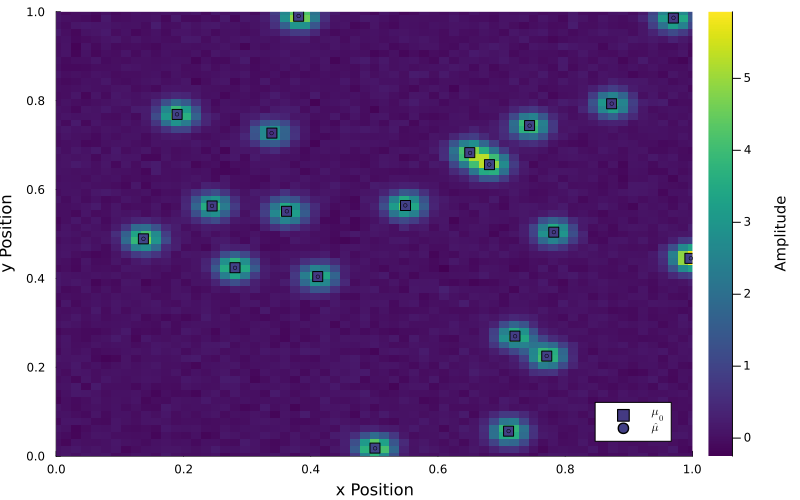

In [227]:
prob = BLASSO(y, ops, domain, λ)
solve!(prob, options=Dict(:maxits => length(a0) + 3, :descent => :LBFGS, :positivity => true))

display(prob.μ)

plt_sfw = deepcopy(plt_obs)
plot_spikes!(plt_sfw, prob.μ, label=L"\hat{μ}", marker=:circle, markersize=2, markerstrokewidth=0.5)